In [1]:
import datetime
from platform import python_version
import random
import warnings

# Ensemble Engines
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from DataSetsAuxFun import *
from PredictAssetData import *

from joblib import load
import pickle
import ruamel.yaml#import yaml

In [2]:
with open(r'params_no_gas_.yml') as file:#with open(r'params_no_gas.yml') as file:
    params = ruamel.yaml.safe_load(file)


In [3]:
warnings.filterwarnings("ignore")

seedNum = params['seedNum']#512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

# %% Constants

DATA_FOLDER_NAME    = params['DATA_FOLDER_NAME'] #'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = params['DATA_FOLDER_PATTERN']#'DataSet001'
DATA_FILE_EXT       = params['DATA_FILE_EXT']#'csv'

PROJECT_DIR_NAME    = params['PROJECT_DIR_NAME']# 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`


# We work according to version 0.8 API.
# See https://github.com/CyVers-AI/CyVersManagement/blob/main/AiTeamOnBoarding.md.
lCsvColName     = params['lCsvColName']
lCsvColNameFlag = params['lCsvColNameFlag']

lSlctedFeaturesRaw    = params['lSlctedFeaturesRaw']#['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]
lSlctedFeaturesCalc   = params['lSlctedFeaturesCalc']#[enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = params['lCatFeatures']#['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
lNumericalFeatures =    [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]

#lTotalFeatures = lNumericalFeatures + lCatFeatures

dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Training
testSetRatio = 0.05#params['testSetRatio']#1 / 3
numKFolds    = params['numKFolds']#3

# Amount USD Outlier threshold
amountUsdOutlierThr = params['amountUsdOutlierThr']#1e9
randomState         = params['randomState'] #42

In [4]:
# %% Loading / Generating Data

lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
#dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, verifySingleSenderId = False, verifyColumns = False, baseFoldePath = '')
dfData, dAssetFile =  LoadCsvFilesDf(lCsvFile, baseFoldePath = '', lColName = lCsvColName, lColFlag =  lCsvColNameFlag)
numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 328
The number of rows (Samples): 1845647, The number of columns: 19, number of unique sender id's: (328,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level'],
      dtype='object') with 19 columns


In [5]:
# %% Pre Process Data
dfData = PreProcessData(dfData, updateInplace = True, amountUsdOutlierThr = amountUsdOutlierThr)

In [6]:
ValidateData(dfData, lSlctedFeaturesRaw)  

In [7]:
# %% Instantiate the Pandas Extension
print('Instantiate the Pandas Extension')
print(f'The number of assets in the data: {dfData.GrpBySender.numGrps}')

Instantiate the Pandas Extension
The number of assets in the data: 327


In [8]:
# %% Calculate Features
dfFeatures = ApplyListOfFeatures(dfData, lSlctedFeaturesCalc)

In [9]:
dfX =  GenDataPredict(dfFeatures , lSlctdFeatures , lNumericalFeatures , lCatFeatures)

In [10]:
lSelectedFeatures_  = lSlctdFeatures
if 'Amount [USD]' in lSelectedFeatures_: lSelectedFeatures_[lSelectedFeatures_.index('Amount [USD]')] =  'Amount USD' ### change of 'Amount [USD]' column string for categorical datas in xgboost

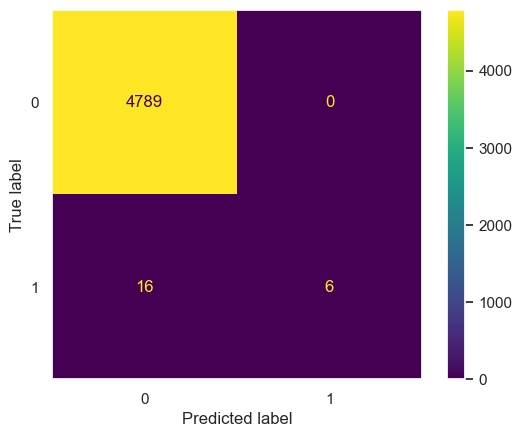

Accuracy         0.996674
F1               0.428571
Precision        1.000000
Recall           0.272727
ROC AUC Score    0.636364
dtype: float64


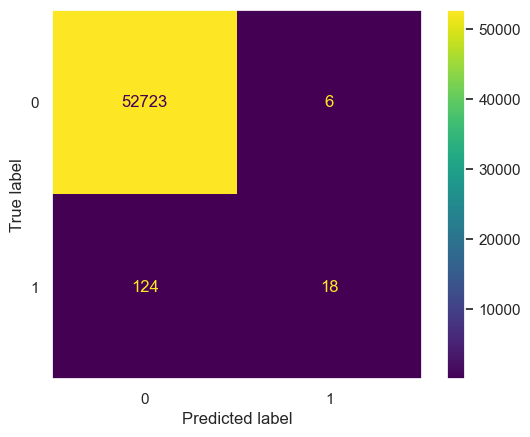

Accuracy         0.997541
F1               0.216867
Precision        0.750000
Recall           0.126761
ROC AUC Score    0.563323
dtype: float64


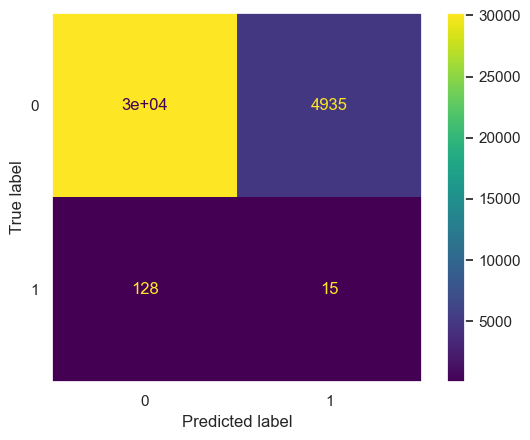

Accuracy         0.856605
F1               0.005890
Precision        0.003030
Recall           0.104895
ROC AUC Score    0.482278
dtype: float64


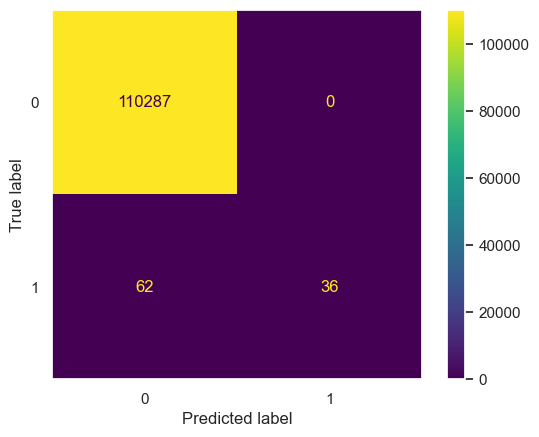

Accuracy         0.999438
F1               0.537313
Precision        1.000000
Recall           0.367347
ROC AUC Score    0.683673
dtype: float64


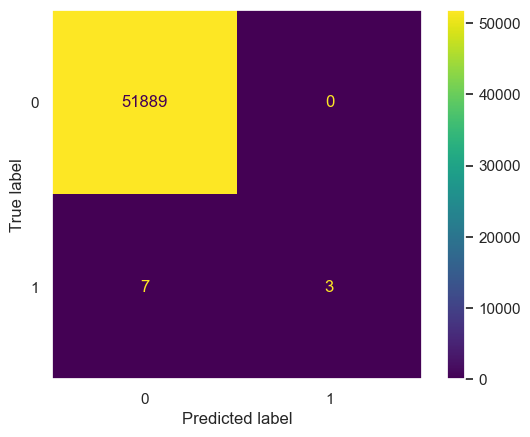

Accuracy         0.999865
F1               0.461538
Precision        1.000000
Recall           0.300000
ROC AUC Score    0.650000
dtype: float64


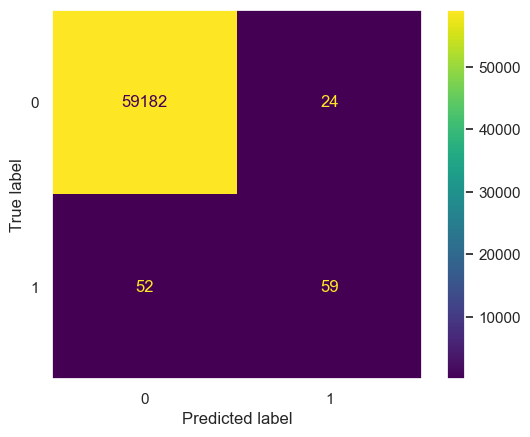

Accuracy         0.998719
F1               0.608247
Precision        0.710843
Recall           0.531532
ROC AUC Score    0.765563
dtype: float64


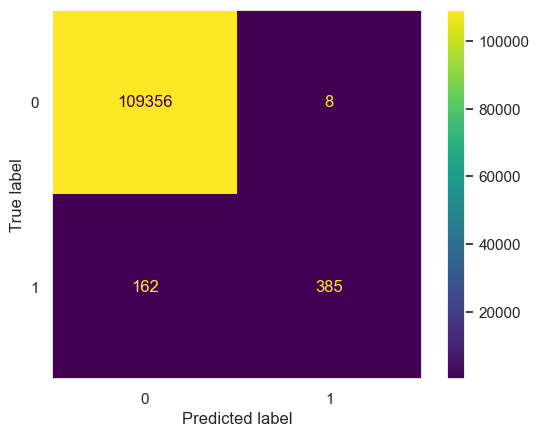

Accuracy         0.998453
F1               0.819149
Precision        0.979644
Recall           0.703839
ROC AUC Score    0.851883
dtype: float64


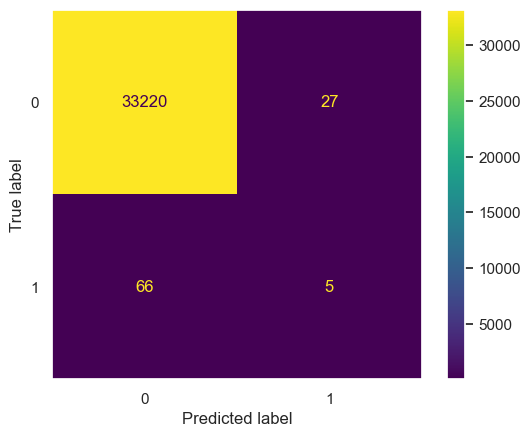

Accuracy         0.997209
F1               0.097087
Precision        0.156250
Recall           0.070423
ROC AUC Score    0.534805
dtype: float64


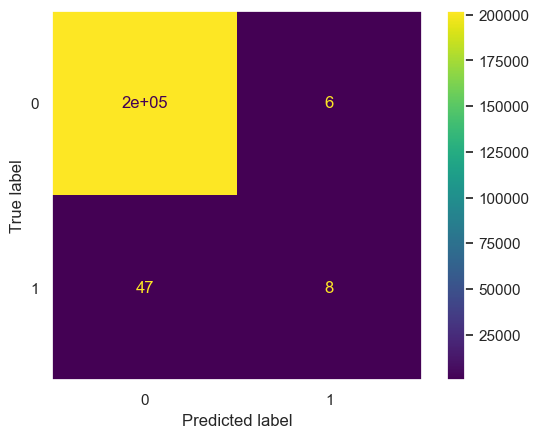

Accuracy         0.999738
F1               0.231884
Precision        0.571429
Recall           0.145455
ROC AUC Score    0.572712
dtype: float64


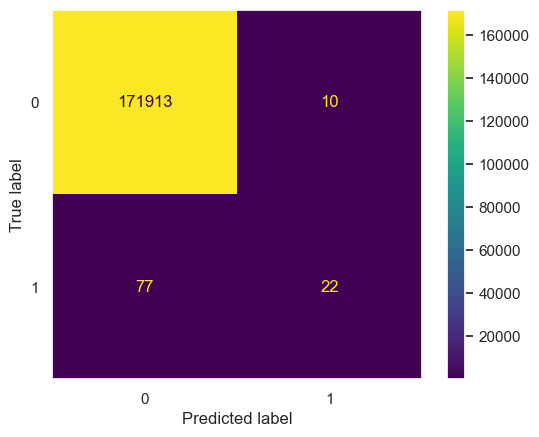

Accuracy         0.999494
F1               0.335878
Precision        0.687500
Recall           0.222222
ROC AUC Score    0.611082
dtype: float64


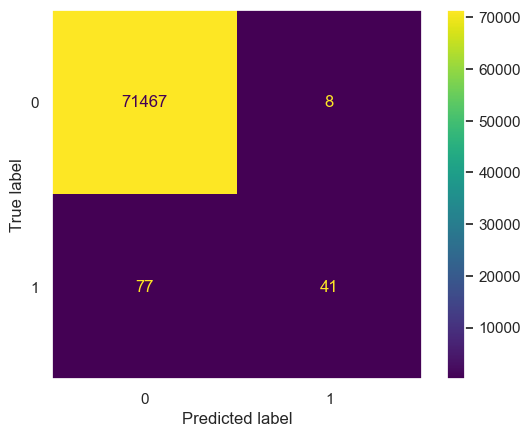

Accuracy         0.998813
F1               0.491018
Precision        0.836735
Recall           0.347458
ROC AUC Score    0.673673
dtype: float64


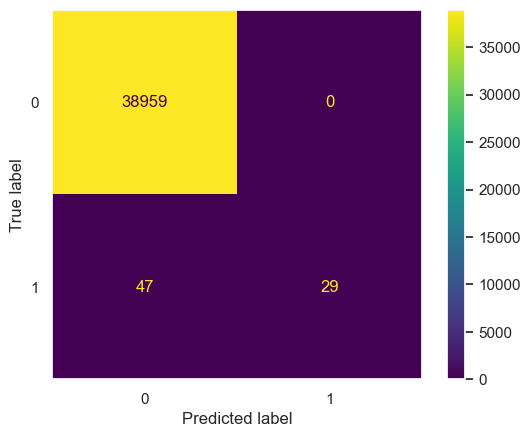

Accuracy         0.998796
F1               0.552381
Precision        1.000000
Recall           0.381579
ROC AUC Score    0.690789
dtype: float64


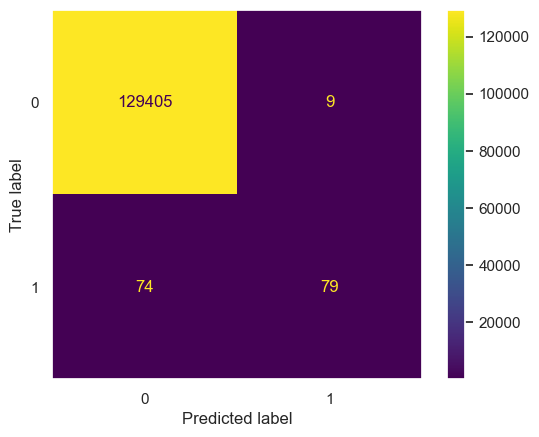

Accuracy         0.999359
F1               0.655602
Precision        0.897727
Recall           0.516340
ROC AUC Score    0.758135
dtype: float64


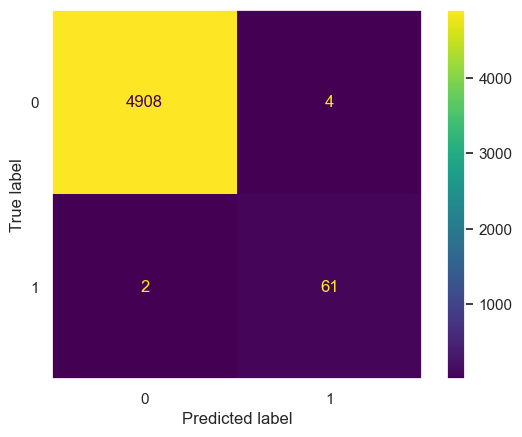

Accuracy         0.998794
F1               0.953125
Precision        0.938462
Recall           0.968254
ROC AUC Score    0.983720
dtype: float64


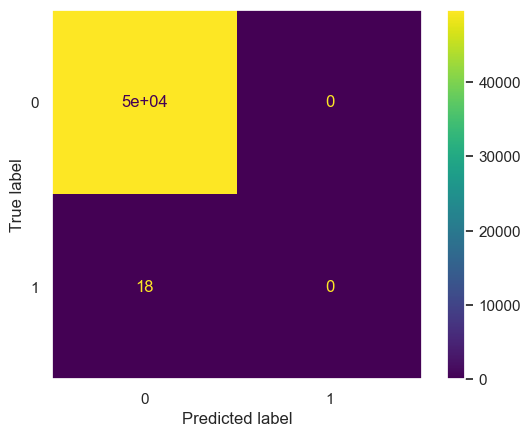

Accuracy         0.999638
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64


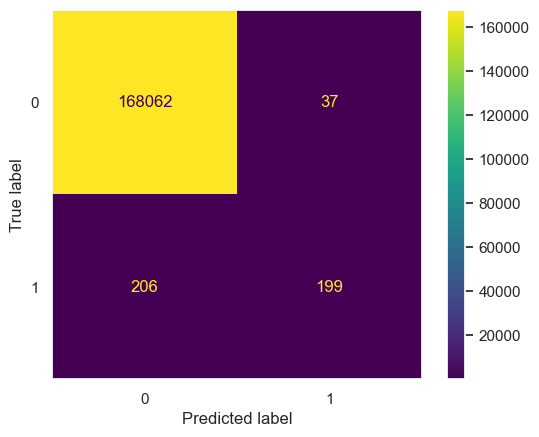

Accuracy         0.998558
F1               0.620905
Precision        0.843220
Recall           0.491358
ROC AUC Score    0.745569
dtype: float64


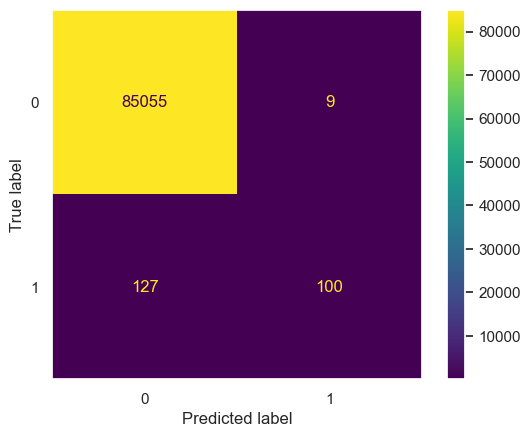

Accuracy         0.998405
F1               0.595238
Precision        0.917431
Recall           0.440529
ROC AUC Score    0.720211
dtype: float64


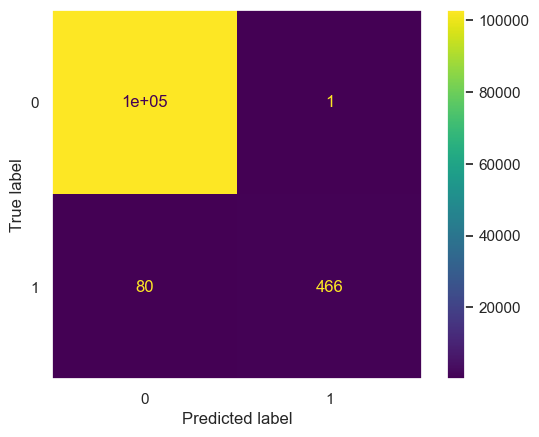

Accuracy         0.999217
F1               0.920039
Precision        0.997859
Recall           0.853480
ROC AUC Score    0.926735
dtype: float64


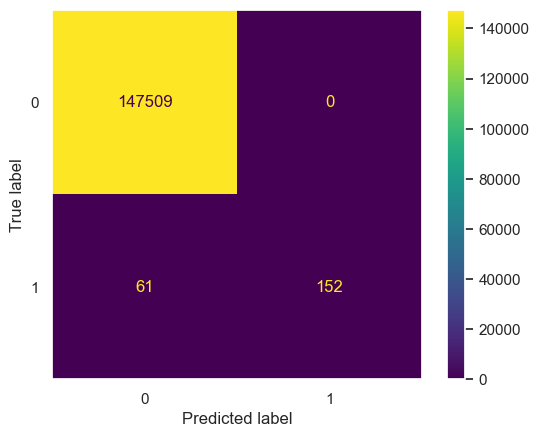

Accuracy         0.999587
F1               0.832877
Precision        1.000000
Recall           0.713615
ROC AUC Score    0.856808
dtype: float64


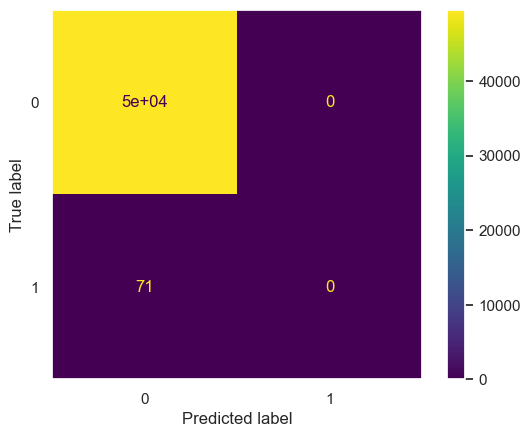

Accuracy         0.998569
F1               0.000000
Precision        0.000000
Recall           0.000000
ROC AUC Score    0.500000
dtype: float64


In [12]:
#models_by_files = TrainModelByFiles(dfX , lSelectedFeatures_ , numKFolds, randomState , seedNum)
models_by_files = TrainModelByFiles(dfX , lSelectedFeatures_ , 20, randomState , seedNum)

In [23]:
lSlctdFeatures 

['Amount',
 'AMOUNT_SUM_USR',
 'AMOUNT_MEAN_ASSET',
 'AMOUNT_STD_USR',
 'AMOUNT_VAR_USR',
 'AMOUNT_MIN_ASSET',
 'AMOUNT_MIN_USR',
 'AMOUNT_MAX_USR',
 'TIME_DIFF_MEAN_USR',
 'TIME_DIFF_STD_USR',
 'TIME_DIFF_MEDIAN_USR',
 'TIME_DIFF_MIN_ASSET',
 'TIME_DIFF_MIN_USR',
 'TIME_DIFF_MAX_ASSET',
 'TIME_DIFF_MAX_USR',
 'COIN_TYPE_USR_MEAN_ASSET_RATIO',
 'COIN_TYPE_COUNT_USR',
 'RECEIVER_TYPE_COUNT_USR',
 'TIME_HOUR',
 'TIME_WEEKDAY',
 'TIME_INTERVL_USR',
 'TIME_DIFF_STD_RATIO_USR_ASSET',
 'TIME_DIFF_MEAN_RATIO_USR_ASSET',
 'MIN_INDICATOR']

In [25]:
lNumericalFeatures , lCatFeatures

(['Amount',
  'AMOUNT_SUM_USR',
  'AMOUNT_MEAN_ASSET',
  'AMOUNT_STD_USR',
  'AMOUNT_VAR_USR',
  'AMOUNT_MIN_ASSET',
  'AMOUNT_MIN_USR',
  'AMOUNT_MAX_USR',
  'TIME_DIFF_MEAN_USR',
  'TIME_DIFF_STD_USR',
  'TIME_DIFF_MEDIAN_USR',
  'TIME_DIFF_MIN_ASSET',
  'TIME_DIFF_MIN_USR',
  'TIME_DIFF_MAX_ASSET',
  'TIME_DIFF_MAX_USR',
  'COIN_TYPE_USR_MEAN_ASSET_RATIO',
  'COIN_TYPE_COUNT_USR',
  'RECEIVER_TYPE_COUNT_USR',
  'TIME_HOUR',
  'TIME_WEEKDAY',
  'TIME_INTERVL_USR',
  'TIME_DIFF_STD_RATIO_USR_ASSET',
  'TIME_DIFF_MEAN_RATIO_USR_ASSET',
  'MIN_INDICATOR'],
 ['Currency', 'Currency Type', 'Receiver Type'])

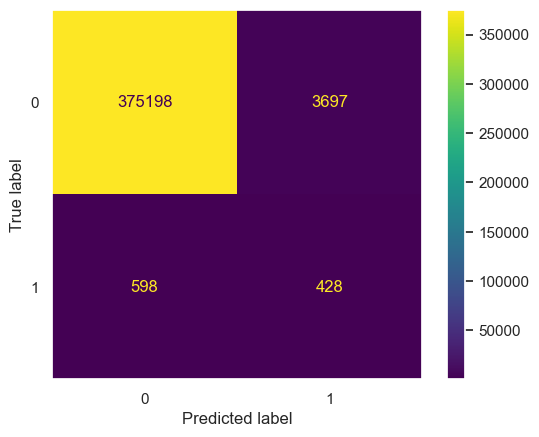

Accuracy         0.988695
F1               0.166181
Precision        0.103758
Recall           0.417154
ROC AUC Score    0.703698
dtype: float64


In [13]:
mX = dfX[lSelectedFeatures_]
vY = dfX['Label']
vTrainIdx = models_by_files[1][0]
vTestIdx = models_by_files[1][1]    

mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]

from sklearn import tree
treeModel = tree.DecisionTreeClassifier()
treeModel.fit(mXTrain, vYTrain)
vYPred = treeModel.predict(mXTest)


DisplayConfusionMatrix(vYTest, vYPred, lClasses = treeModel.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))



In [18]:
dfX

,Amount,AMOUNT_SUM_USR,AMOUNT_MEAN_ASSET,AMOUNT_STD_USR,AMOUNT_VAR_USR,AMOUNT_MIN_ASSET,AMOUNT_MIN_USR,AMOUNT_MAX_USR,TIME_DIFF_MEAN_USR,TIME_DIFF_STD_USR,...,COIN_TYPE_COUNT_USR,RECEIVER_TYPE_COUNT_USR,TIME_HOUR,TIME_WEEKDAY,TIME_INTERVL_USR,TIME_DIFF_STD_RATIO_USR_ASSET,TIME_DIFF_MEAN_RATIO_USR_ASSET,MIN_INDICATOR,Label,Sender ID
905528,-0.001091,-0.229719,0.505866,-0.111120,-0.004414,-0.003376,-0.023475,-0.186283,131.834803,-0.246340,...,-0.204302,0.199889,-0.152373,0.508359,11.534513,-0.290924,0.272360,1.304072,0,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c
905527,-0.001091,-0.229717,0.505866,-0.111152,-0.004414,-0.003376,-0.022668,-0.186249,-0.213235,-0.246340,...,-0.204302,0.199889,-0.447823,-0.489465,-0.430507,-0.290924,-0.202172,1.304072,0,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c
905526,-0.001091,-0.224292,0.505866,-0.037983,-0.004391,-0.003376,-0.023032,-0.170051,6.067256,9.739381,...,-0.204302,0.199889,-0.152373,0.508359,9.812974,-0.264961,-0.179602,1.304072,0,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c
905525,-0.001091,-0.224292,0.505866,-0.037983,-0.004391,-0.003376,-0.023032,-0.170051,6.067256,9.739381,...,-0.204302,0.199889,-0.743273,0.009447,9.812974,-0.264961,-0.179602,-0.766829,0,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c
905524,-0.001091,-0.224292,0.505866,-0.037983,-0.004391,-0.003376,-0.023032,-0.170051,6.067256,9.739381,...,-0.204302,0.199889,-0.004648,0.508359,9.812974,-0.264961,-0.179602,-0.766829,0,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830123,-0.001091,-0.229527,-0.111441,-0.111145,-0.004414,-0.002593,-0.023317,-0.186276,-0.210043,-0.241103,...,-0.204302,-5.002296,-0.595548,-0.988377,-0.338556,-0.290371,-0.202089,-0.766829,0,0x663a5c229c09b049e36dcc11a9b0d4a8eb9db214
1829828,-0.001091,-0.229527,-0.111441,-0.111145,-0.004414,-0.002593,-0.023317,-0.186276,-0.210043,-0.241103,...,-0.204302,-5.002296,-0.595548,-0.988377,-0.338556,-0.290371,-0.202089,-0.766829,0,0x663a5c229c09b049e36dcc11a9b0d4a8eb9db214
1837022,-0.001091,-0.229527,-0.111441,-0.111145,-0.004414,-0.002593,-0.023317,-0.186276,-0.210043,-0.241103,...,-0.204302,-5.002296,-0.447823,-0.988377,-0.338556,-0.290371,-0.202089,-0.766829,0,0x663a5c229c09b049e36dcc11a9b0d4a8eb9db214
1831017,-0.001091,-0.229527,-0.111441,-0.111145,-0.004414,-0.002593,-0.023317,-0.186276,-0.210043,-0.241103,...,-0.204302,-5.002296,-0.300098,-0.988377,-0.338556,-0.290371,-0.202089,-0.766829,0,0x663a5c229c09b049e36dcc11a9b0d4a8eb9db214


[Text(0.9516349588937141, 0.9848484848484849, 'COIN_TYPE_COUNT_USR <= 10.426\ngini = 0.003\nsamples = 1301839\nvalue = [1299677, 2162]'),
 Text(0.9089319122028438, 0.9545454545454546, 'AMOUNT_VAR_USR <= 0.423\ngini = 0.003\nsamples = 1300916\nvalue = [1299051, 1865]'),
 Text(0.8320188104442268, 0.9242424242424242, 'AMOUNT_MIN_ASSET <= 0.0\ngini = 0.003\nsamples = 1300581\nvalue = [1298822, 1759]'),
 Text(0.7685744044996337, 0.8939393939393939, 'COIN_TYPE_COUNT_USR <= 1.939\ngini = 0.002\nsamples = 1295733\nvalue = [1294202, 1531]'),
 Text(0.6978079005366868, 0.8636363636363636, 'TIME_DIFF_MIN_ASSET <= 0.001\ngini = 0.002\nsamples = 1269691\nvalue = [1268550, 1141]'),
 Text(0.5860003632917254, 0.8333333333333334, 'AMOUNT_MIN_USR <= 0.424\ngini = 0.002\nsamples = 1268857\nvalue = [1267771, 1086]'),
 Text(0.47741666753061845, 0.803030303030303, 'AMOUNT_MEAN_ASSET <= 2.37\ngini = 0.002\nsamples = 1262949\nvalue = [1261962, 987]'),
 Text(0.36249693297116475, 0.7727272727272727, 'TIME_DIFF_M

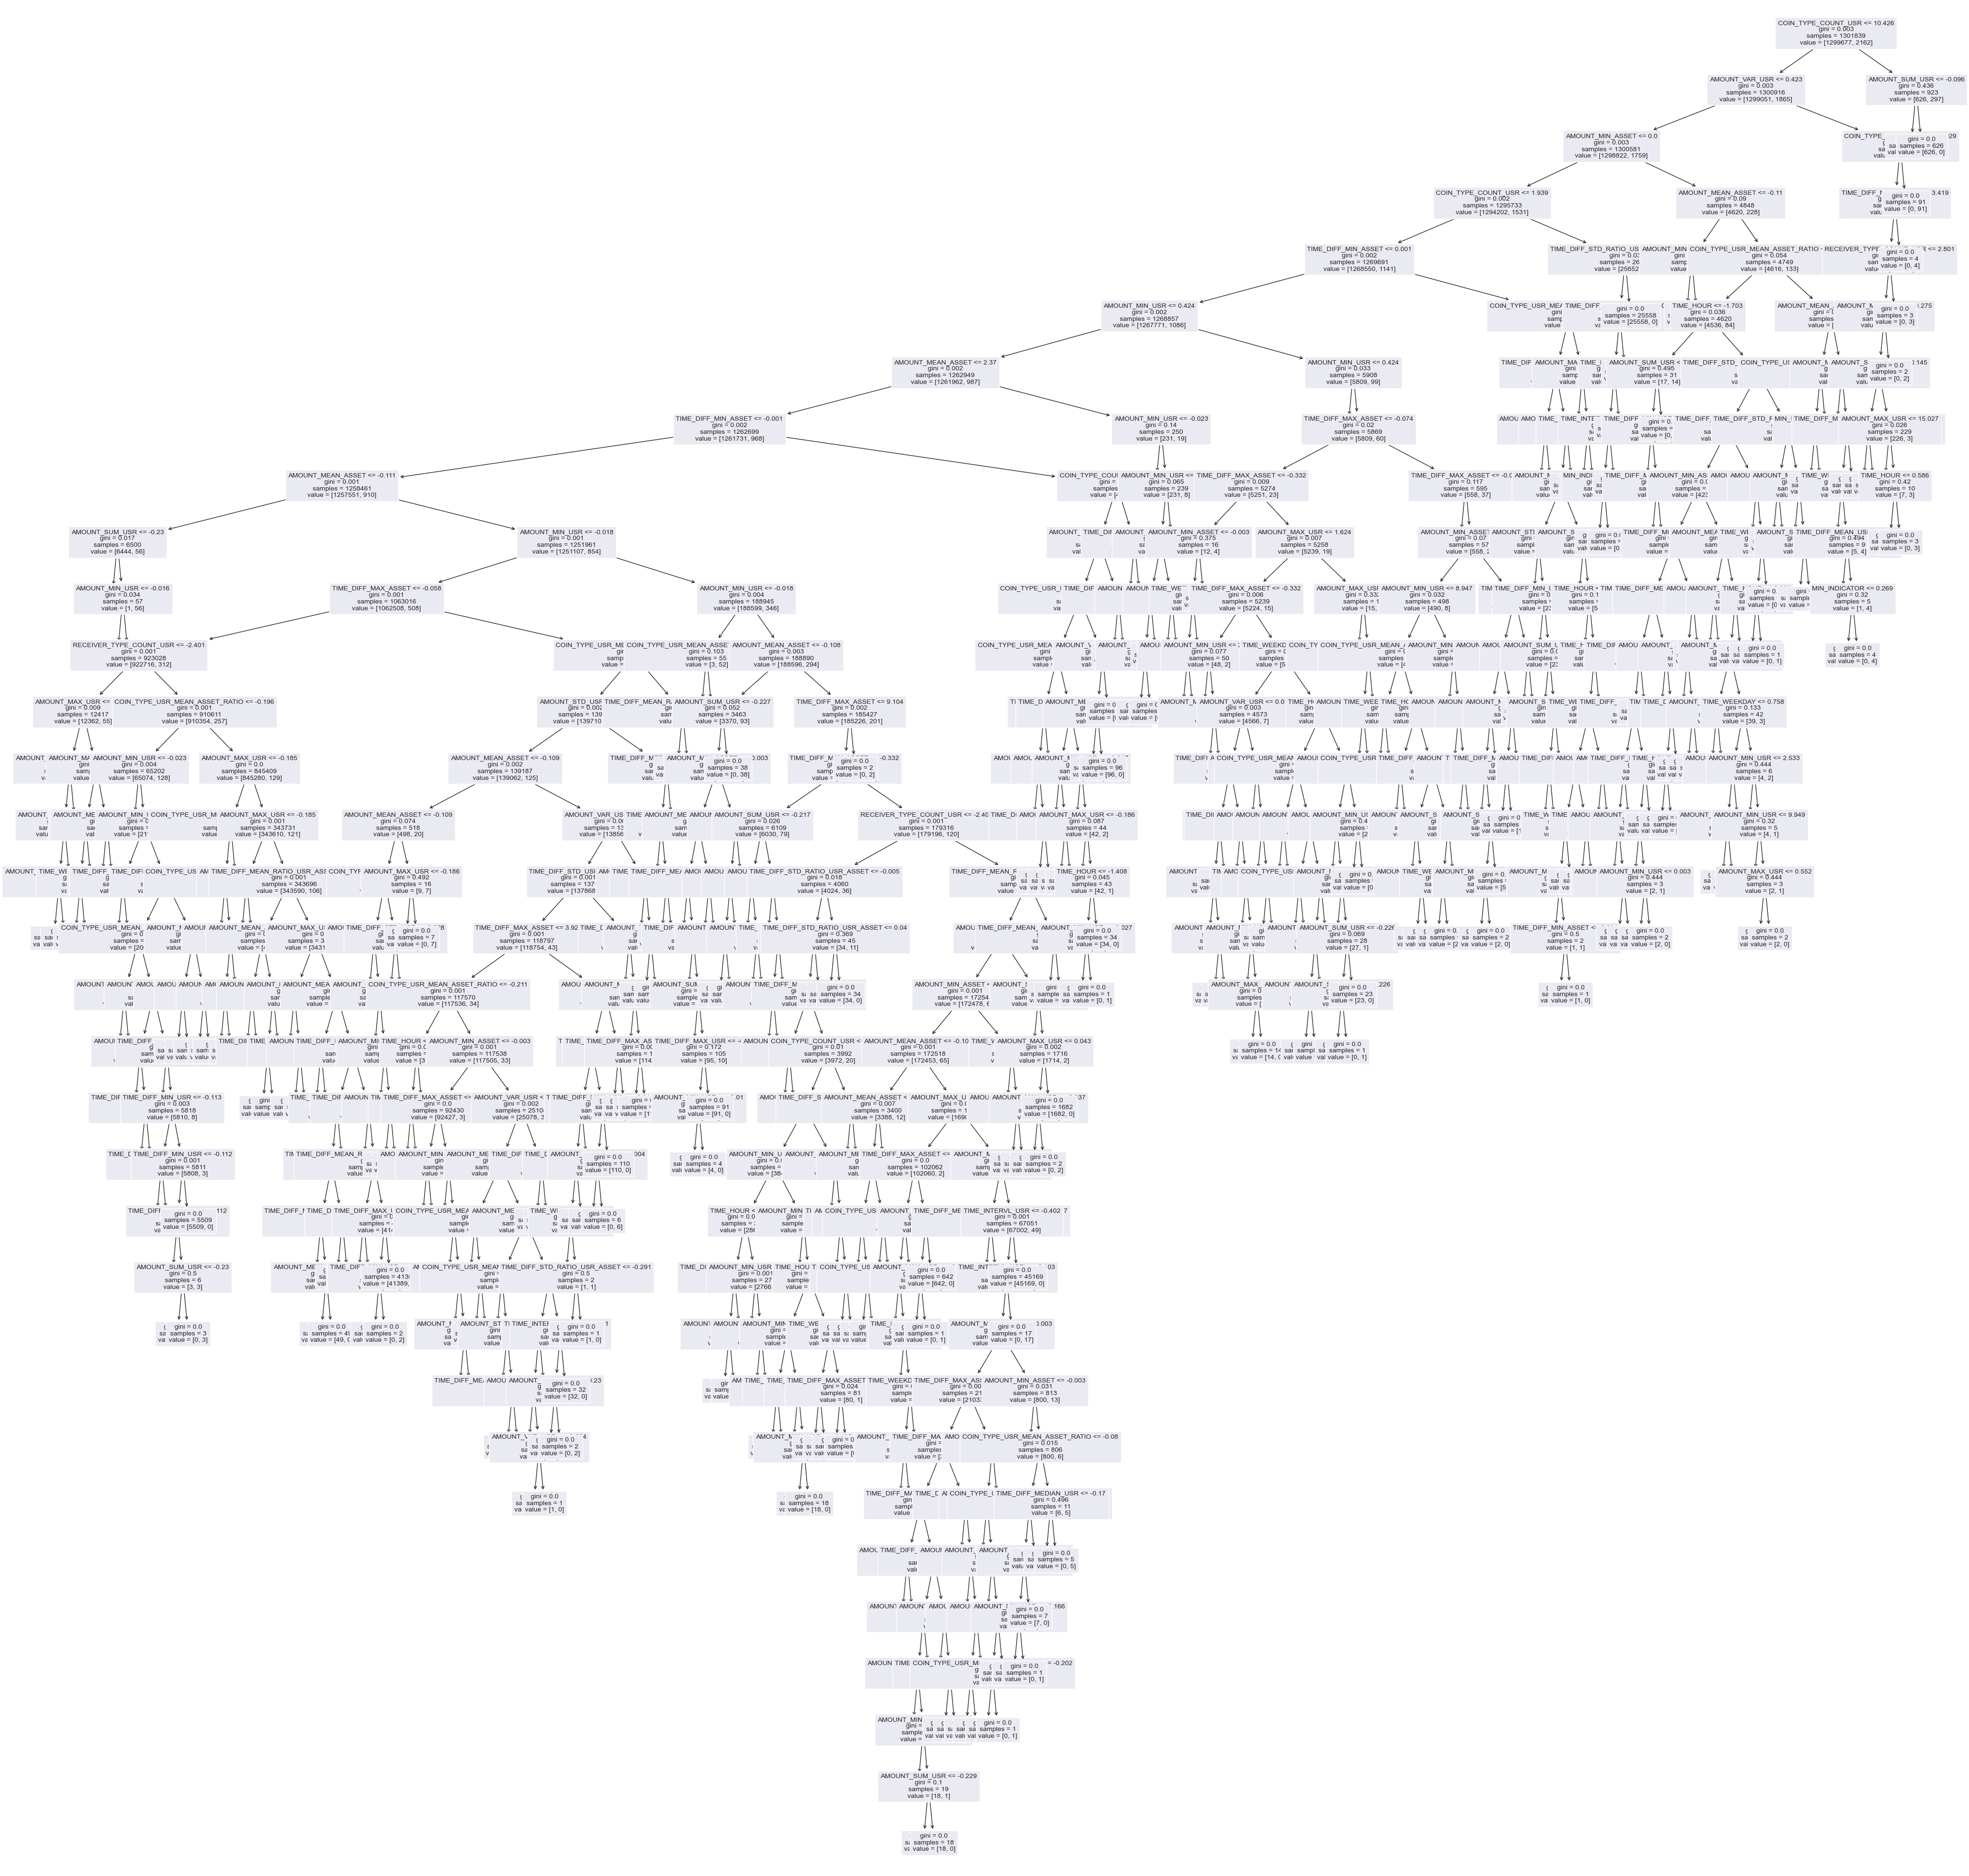

In [17]:
fig = plt.figure(figsize=(50,50))
tree.plot_tree(treeModel,feature_names=lSelectedFeatures_, fontsize = 10)

In [20]:
import graphviz

dot_data = tree.export_graphviz(treeModel, out_file=None, 
                                feature_names=lSelectedFeatures_,  
                                filled=True)

graph = graphviz.Source(dot_data, format="png") 


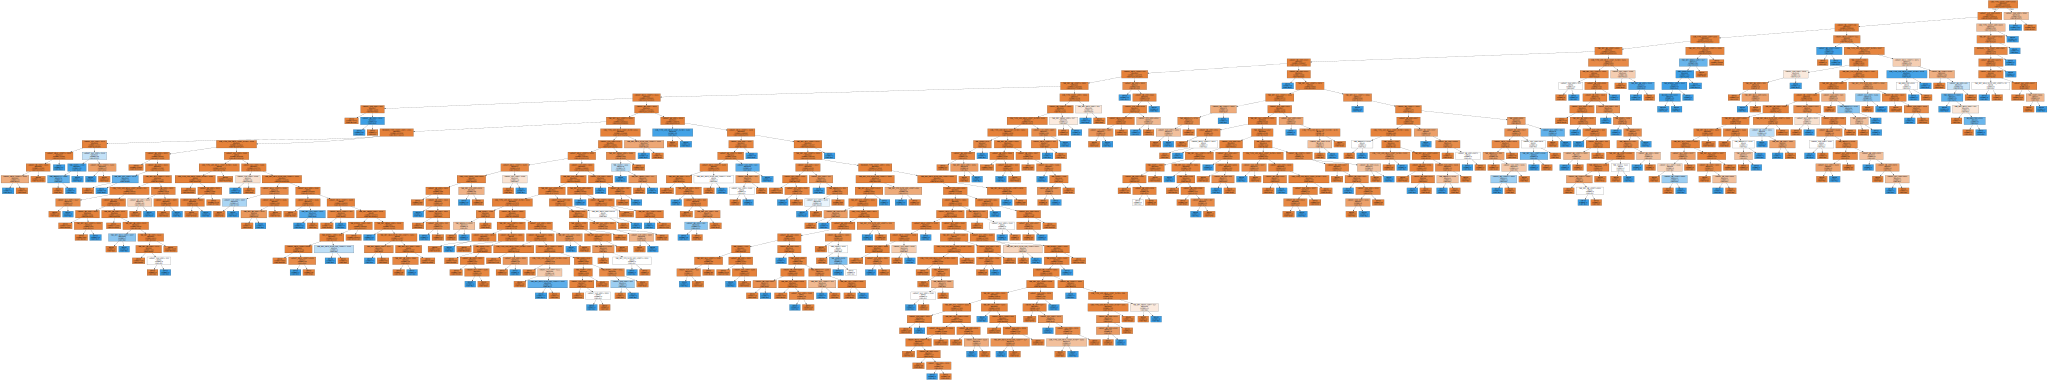

In [21]:
graph

In [12]:
models_by_files[1]

[array([      0,       1,       2, ..., 1681541, 1681613, 1681650]),
 array([    134,     239,     241, ..., 1681757, 1681758, 1681759]),
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=True,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=250,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=512,
               reg_alpha=0, reg_lambda=1, ...)]

In [ ]:
models_by_transacts = TrainModelByTransact(dfX ,lSelectedFeatures_  , lCatFeatures ,lSelectedFeatures_ , numKFolds, randomState )

In [ ]:
##################### saving :
xgbModel = models_by_files[-7][2] ### <<--- choose best one
lRawFeatures = lSlctedFeaturesRaw
lProcessedFeatures = lSlctedFeaturesCalc
lSelectedFeatures = lSlctdFeatures

TIME_STAMP_FORMAT = '%Y_%m_%d_%H_%M_%S' #<! For the strftime() formatter
MODEL_FILE_NAME = 'Model'
MODEL_FILE_EXT  = 'pkl' #<! Used to be JSON for XGBoost, Needs to figure it out

folderPostfix   = datetime.datetime.now().strftime(TIME_STAMP_FORMAT)
folderName      = MODEL_FILE_NAME + '_' + folderPostfix

modelFileName   = MODEL_FILE_NAME + '.' + MODEL_FILE_EXT

if not os.path.exists(folderName):
    os.mkdir(folderName)

pickle.dump(xgbModel, open(os.path.join(folderName, modelFileName), "wb"))
pickle.dump(lRawFeatures, open(os.path.join(folderName, 'lRawFeatures.pkl'), "wb"))
pickle.dump(lProcessedFeatures, open(os.path.join(folderName, 'lProcessedFeatures.pkl'), "wb"))
pickle.dump(lCatFeatures, open(os.path.join(folderName, 'lCatFeatures.pkl'), "wb")) 
pickle.dump(lSelectedFeatures, open(os.path.join(folderName, 'lSelectedFeatures.pkl'), "wb"))

In [ ]:
model_file_hash = hashfile(os.path.join(folderName, modelFileName))

In [ ]:
params['MODEL_FILE_HASH'] = model_file_hash

In [ ]:
with open('params_no_gas_.yml','w') as yamlfile:
        ruamel.yaml.safe_dump(params, yamlfile)
 